# Определение возраста покупателей

  Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей.  
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.  

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras

from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

Отображение не более 2х знаков после запятой

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

Загружаем данные

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv')
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Пропуски отсутствуют, форматы в порядке

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


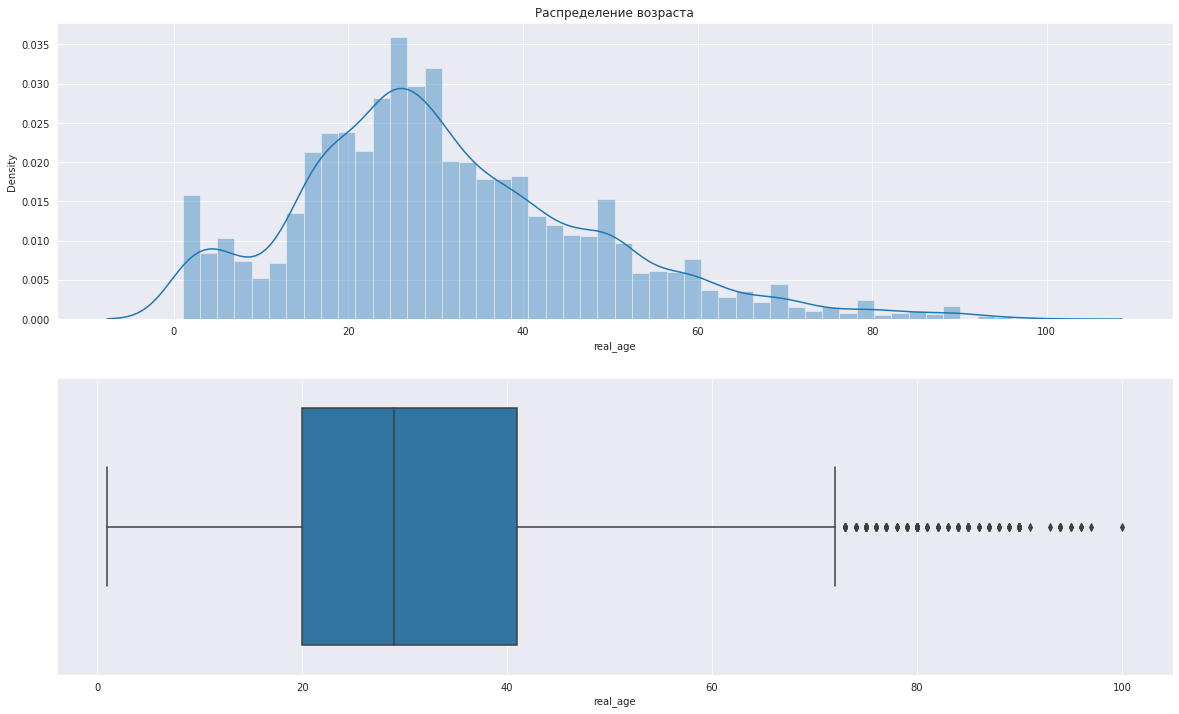

In [5]:
plt.figure(figsize=(20,12))
sns.set_style('darkgrid')
plt.subplot(211)
sns.distplot(data['real_age'], bins=50)
plt.title('Распределение возраста')

plt.subplot(212)
sns.boxplot(data['real_age'])


plt.show()

В датасете основная масса фотографий людей с 20 до 40 лет, больше всего фотографий людей в возрасте от 25 до 30 лет. Фотографии с людьми старше 70 лет встречаются крайне редко (выбросы). Распределение имеет вид нормального с положительной скошенностью, так как медиана меньше среднего значения.

In [6]:
data['real_age'].describe()

count   7,591.00
mean       31.20
std        17.15
min         1.00
25%        20.00
50%        29.00
75%        41.00
max       100.00
Name: real_age, dtype: float64

In [7]:
data['real_age'].value_counts().head()

30    317
25    315
27    229
26    226
28    217
Name: real_age, dtype: int64

Совмещаем фотографии с датасетом

In [8]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
flow_datagen = datagen.flow_from_dataframe(dataframe = data,
    directory = '/datasets/faces/final_files',
    x_col="file_name", 
    y_col="real_age", 
    class_mode='raw',
    batch_size=16,                                     
    target_size=(224,224),
    seed=12345,
    subset='training',
    shuffle=True)

Found 5694 validated image filenames.


Получаем пары картинок с метками

In [9]:
features, target = next(flow_datagen)

Выводим 16 фото и возраст человека на фото

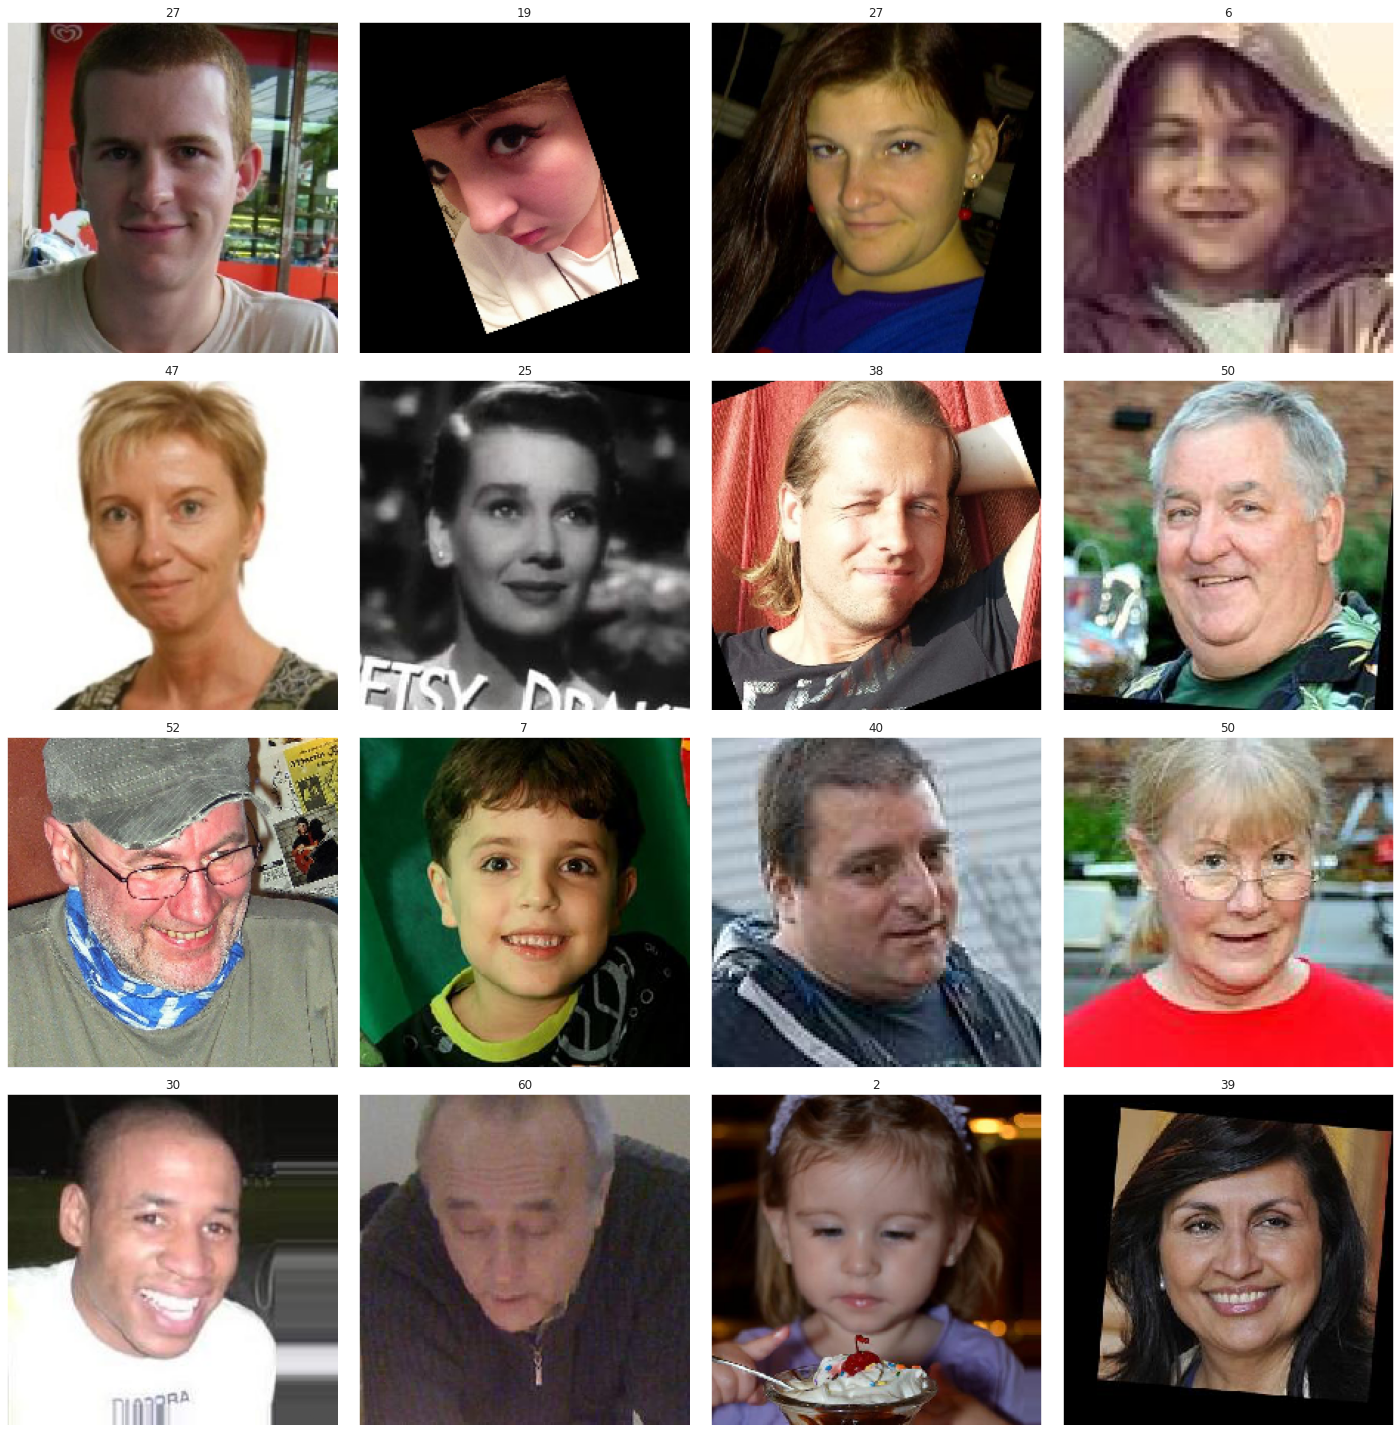

In [10]:
fig = plt.figure(figsize=(20,20))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])  
    plt.tight_layout()

Цветные изображения RGB считывали размером 224 * 224, расположены преимущественно вертикально. Есть черно-белые фотографии, а также фотографии, где люди смотрят не в камеру

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
 

def load_train(path):
    df_train = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
      dataframe=df_train,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      seed=12345,
      subset='training',
      shuffle=True
      )
    return train_datagen_flow
 

def load_test(path):
    df_test = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
      validation_split=0.25,
      rescale=1./255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(
      dataframe=df_test,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      seed=12345,
      subset='validation',
      shuffle=False
      )
    return test_datagen_flow
 

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model
 

def train_model(model, train_data, test_data, batch_size=None, epochs=14,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```


Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/14
178/178 - 158s - loss: 256.6229 - mae: 11.3492 - val_loss: 771.6574 - val_mae: 22.9640
Epoch 2/14
178/178 - 37s - loss: 75.6894 - mae: 6.5224 - val_loss: 761.5020 - val_mae: 22.6867
Epoch 3/14
178/178 - 37s - loss: 49.6180 - mae: 5.3336 - val_loss: 208.7142 - val_mae: 11.1920
Epoch 4/14
178/178 - 38s - loss: 35.1489 - mae: 4.5297 - val_loss: 104.3519 - val_mae: 7.7195
Epoch 5/14
178/178 - 37s - loss: 25.9589 - mae: 3.9078 - val_loss: 73.3468 - val_mae: 6.3397
Epoch 6/14
178/178 - 37s - loss: 21.3049 - mae: 3.5295 - val_loss: 73.9817 - val_mae: 6.5920
Epoch 7/14
178/178 - 37s - loss: 18.6397 - mae: 3.2669 - val_loss: 65.6456 - val_mae: 6.1790
Epoch 8/14
178/178 - 38s - loss: 14.4738 - mae: 2.8765 - val_loss: 70.3936 - val_mae: 6.3487
Epoch 9/14
178/178 - 37s - loss: 12.2449 - mae: 2.6779 - val_loss: 86.8564 - val_mae: 7.3891
Epoch 10/14
178/178 - 37s - loss: 10.7131 - mae: 2.4954 - val_loss: 68.6861 - val_mae: 6.2927
Epoch 11/14
178/178 - 37s - loss: 9.5410 - mae: 2.3311 - val_loss: 63.4558 - val_mae: 5.9338
Epoch 12/14
178/178 - 38s - loss: 8.7882 - mae: 2.2475 - val_loss: 61.0042 - val_mae: 5.8331
Epoch 13/14
178/178 - 38s - loss: 8.0065 - mae: 2.1391 - val_loss: 71.0702 - val_mae: 6.2132
Epoch 14/14
178/178 - 38s - loss: 7.4914 - mae: 2.0669 - val_loss: 61.0992 - val_mae: 5.7990

60/60 - 9s - loss: 61.0992 - mae: 5.7990
Test MAE: 5.7990
```

## Анализ обученной модели

1. получили датасет с набороом фотографий людей и указанием их возраста для построения модели компьютерного зрения с целью определения возраста по фотографиям (метрика МАЕ)
2. в данных отсутствуют пропуски, в столбцах верные форматы
3. исследовательский анализ показал, что в датасете основная масса фотографий людей с 20 до 40 лет, больше всего фотографий людей в возрасте от 25 до 30 лет. Данные в столбце возраст имеют вид нормального распределения
4. построили модель с помощью библиотеки __keras__ с использованием нейросети __ResNet50__. Изменили верхушку нейросети на пуллинг GlobalAveragePooling2D для обобщения и полносвзяным слоем с одним нейроном, так как перед нами стояла задача регрессии. Использовали метрику МАЕ по условиям поставленной задачи, а также MSE в качестве функции потерь для увеличения скорости обучения модели
5. наилучшее значение метрики показала модель с активатором __relu__ в заключительном полносвзяном слое (вероятно потому, что возраст всегда положительное значение) и начальным шагом градиентного спуска равным 0.0001 на 14-ти эпохах. Использование горизонтального отражения  положительно сказалось на модели. Целевое значение метрики достигнуто.